In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Activation, Input, Embedding, Reshape, MaxPooling1D, Conv1D
from keras.layers import LSTM, GRU, Conv1D
from keras.layers import Dropout, BatchNormalization, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.activations import sigmoid
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.callbacks import TensorBoard
import numpy as np
import random
import sys
import os

Using TensorFlow backend.


In [2]:
import re
from libs.text_utils import split_raw_into_sentences

In [3]:
from libs.utils import text_preprocess

In [4]:
with open('data/dostoewskij.txt', encoding='utf-8') as f:
    dostoewskij_text = f.read().lower()
with open('data/non_dostoewskij_texts.txt', encoding='utf-8') as f:
    non_dostoewskij_text = f.read().lower()

sentenced_dostoewskij = split_raw_into_sentences(dostoewskij_text)
sentenced_non_dostoewskij = split_raw_into_sentences(non_dostoewskij_text)

sentenced_dostoewskij = text_preprocess(sentenced_dostoewskij)
sentenced_non_dostoewskij = text_preprocess(sentenced_non_dostoewskij)

dostoewskij_sentences = sentenced_dostoewskij.split('\n')
non_dostoewskij_sentences = sentenced_non_dostoewskij.split('\n')

#dostoewskij_text = clear_text_from_rare_chars(dostoewskij_text, delete_enters=True)
#non_dostoewskij_text = clear_text_from_rare_chars(non_dostoewskij_text, delete_enters=True)

print('dostoewskij_length:\t', len(dostoewskij_text))
print('non_dostoewskij_length:\t', len(non_dostoewskij_text))

dostoewskij_length:	 4967030
non_dostoewskij_length:	 175060228


In [5]:
s = set(sentenced_dostoewskij)
print(len(s))
s2 = set(sentenced_non_dostoewskij)
print(len(s2))

39
39


In [6]:
from libs.utils import load_transformer

transformer = load_transformer('models/shm_c1')

chars = transformer.tokens
char_cats = len(chars)
print('total chars:', char_cats)

total chars: 42


In [1]:
print_len = 200
pos = np.random.randint(len(dostoewskij_text))
print(dostoewskij_text[pos:pos+print_len])
print('-' * 100)
pos = np.random.randint(len(non_dostoewskij_text))
print(non_dostoewskij_text[pos:pos+print_len])

NameError: name 'np' is not defined

In [8]:
n_batches = len(dostoewskij_sentences)
batch_size = 16
max_len = 200

In [9]:
from libs.utils import pad

# transform text into sequence of indices
pad_idx = char_cats
dostoewskij_indexes     = np.array([pad(transformer.transform(sent), max_len, pad_idx) for sent in dostoewskij_sentences])
non_dostoewskij_indexes = np.array([pad(transformer.transform(sent), max_len, pad_idx) for sent in non_dostoewskij_sentences])

In [10]:
from libs.utils import split_data_into_correct_batches_for_stateful_rnnlit_data_into_correct_batches as split_data_into_correct_batches_sentences

X, y = split_data_into_correct_batches_sentences(dostoewskij_indexes, non_dostoewskij_indexes, 
                                                 n_batches, max_len, make_equal_folding=True)

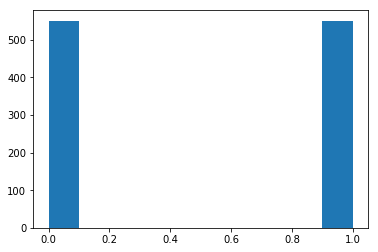

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

a = plt.hist(y)

In [12]:
from keras.losses import sparse_categorical_crossentropy

In [13]:
def create_cnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats+1, int(char_cats / 1.5))(inp)
    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(v) # None, 200, 64
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(4, padding='same')(x) # None, 50, 64

    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(x) # None, 50, 128
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(2, padding='same')(x) # None, 25, 128

    x = Conv1D(256, kernel_size=8, activation='relu', padding='same')(x) # None, 25, 256
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(5, padding='same')(x) # None, 5, 256

    h = Flatten()(x) # None, 5*256
    y = Dense(2, activation='softmax')(h) # None, 512
    model = Model(inp, y, name="char_cnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [14]:
rnn = create_cnn()

In [15]:
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 28)           1204      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          28800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           131200    
__________

In [16]:
n_epochs = 8
n_batches = len(dostoewskij_indexes)
histories = []
for epoch in range(n_epochs):
    X, y = split_data_into_correct_batches_sentences(dostoewskij_indexes, non_dostoewskij_indexes, make_equal_folding=True)
    histories.append(rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1))

Epoch 1/1
1101/1101 [==============================] - 8s - loss: 1.3175 - acc: 0.5967     
Epoch 1/1
1101/1101 [==============================] - 1s - loss: 0.8151 - acc: 0.6876     
Epoch 1/1
1101/1101 [==============================] - 1s - loss: 0.6303 - acc: 0.7584     
Epoch 1/1
1101/1101 [==============================] - 1s - loss: 0.4942 - acc: 0.8156     
Epoch 1/1
1101/1101 [==============================] - 1s - loss: 0.3924 - acc: 0.8574     
Epoch 1/1
1101/1101 [==============================] - 1s - loss: 0.3253 - acc: 0.8874     
Epoch 1/1
1101/1101 [==============================] - 1s - loss: 0.2820 - acc: 0.9074     
Epoch 1/1
1101/1101 [==============================] - 1s - loss: 0.2034 - acc: 0.9237     


In [17]:
rnn.save('models/discriminator_style_rnn_model.h5')